## Import All necessary libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import cv2

sns.set(style="darkgrid", font_scale=1.4)

## Task 1

The task is to practice ANN using MNIST dataset, see how different activation functions act. Write train and test stages

### Create Dataset

In [2]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

root = '/'
train_data = datasets.MNIST(root, train=True, transform=transformer, download=True)
test_data = datasets.MNIST(root, train=False, transform=transformer, download=True)

### Create DataLoaders

In [3]:
batch_size = 128

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Create Model using ELU as an activation function

Task: Create Dense neural network

Create it using class Sequential:


*   nn.Flatten
*   two hidden layer with 128 neurons and activation function ELU
*   Output layer with 10 neurons





In [4]:
print(train_data[0][0].shape)

torch.Size([1, 28, 28])


In [5]:
shape = train_data[0][0].shape
features = shape[0] * shape[1] * shape[2]
classes = 10

In [6]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
)

### Choose loss function and optimizer

In [7]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dataloaders = {
    "train": train_dataloader,
    "val": test_dataloader,
}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Train Stage

Template that may help in 90% of situation:
```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

#### **But we will separate train and eval stages**

In [9]:
def train_epoch(model, criterion, optimizer, dataloader, device):
  model.train()

  cur_loss = 0
  cur_correct = 0
  total_data = 0
  for x_batch, y_batch in dataloader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    
    output = model(x_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
    
    preds = output.argmax(-1)

    cur_loss += loss.item() * x_batch.size(0)
    cur_correct += (y_batch == preds).sum().cpu().numpy()
    total_data += x_batch.size(0)

  epoch_loss = cur_loss / total_data
  epoch_acc = cur_correct / total_data

  return epoch_loss, epoch_acc

In [10]:
def eval_epoch(model, criterion, dataloader, device):
  model.eval()

  cur_loss = 0
  cur_correct = 0
  total_data = 0

  for x_batch, y_batch in dataloader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = criterion(output, y_batch)
      preds = output.argmax(-1)

    cur_loss += loss.item() * x_batch.size(0)
    cur_correct += (preds == y_batch).sum().cpu().numpy()
    total_data += x_batch.size(0)

  loss = cur_loss / total_data
  acc = cur_correct / total_data

  return loss, acc

In [11]:
def train(model, epochs, criterion, optimizer, device, dataloaders):
  history = {
      'train_loss': [],
      'val_loss': [],
      'train_acc': [],
      'val_acc': [],
  }
  model.to(device)
  log_template = "Epoch {:03d}/{:03d}:  train_loss: {:0.7f}  |  val_loss: {:0.7f}  |  train_acc: {:0.7f}  |  val_acc: {:0.7f}"
  for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, dataloaders['train'], device)
    val_loss, val_acc = eval_epoch(model, criterion, dataloaders['val'], device)
    
    print(log_template.format(epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

  return history

In [12]:
epochs = 10

history = train(model, epochs, criterion, optimizer, device, dataloaders)

Epoch 001/010:  train_loss: 0.3774787  |  val_loss: 0.2171675  |  train_acc: 0.8891500  |  val_acc: 0.9350000
Epoch 002/010:  train_loss: 0.1705391  |  val_loss: 0.1432420  |  train_acc: 0.9478833  |  val_acc: 0.9553000
Epoch 003/010:  train_loss: 0.1182386  |  val_loss: 0.1095045  |  train_acc: 0.9639000  |  val_acc: 0.9643000
Epoch 004/010:  train_loss: 0.0939774  |  val_loss: 0.1029438  |  train_acc: 0.9706667  |  val_acc: 0.9683000
Epoch 005/010:  train_loss: 0.0767081  |  val_loss: 0.0886797  |  train_acc: 0.9759500  |  val_acc: 0.9720000
Epoch 006/010:  train_loss: 0.0682396  |  val_loss: 0.0884363  |  train_acc: 0.9782167  |  val_acc: 0.9723000
Epoch 007/010:  train_loss: 0.0585091  |  val_loss: 0.0836109  |  train_acc: 0.9811500  |  val_acc: 0.9735000
Epoch 008/010:  train_loss: 0.0514747  |  val_loss: 0.0769940  |  train_acc: 0.9835500  |  val_acc: 0.9746000
Epoch 009/010:  train_loss: 0.0441522  |  val_loss: 0.0772523  |  train_acc: 0.9855167  |  val_acc: 0.9768000
Epoch 010/

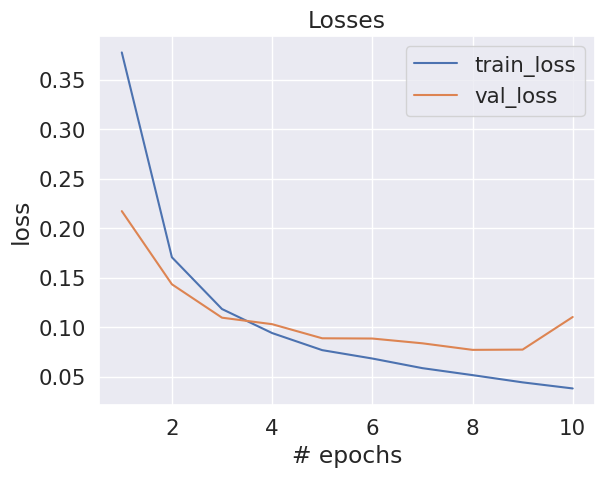

In [13]:
plt.plot(range(1, epochs+1), history['train_loss'], label='train_loss')
plt.plot(range(1, epochs+1), history['val_loss'], label='val_loss')
plt.title('Losses')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

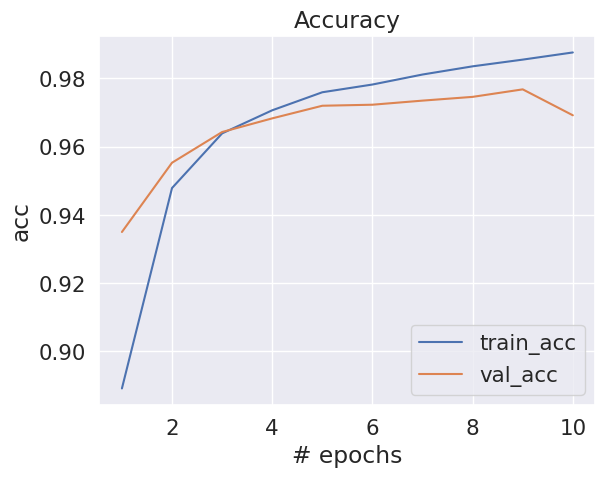

In [14]:
plt.plot(range(1, epochs+1), history['train_acc'], label='train_acc')
plt.plot(range(1, epochs+1), history['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('# epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

#### It seems that our model starts to overfit the train dataset

## Lets try different activation functions

In [15]:
def test_activation_fn(activation):
  print(f'\ttesting: {str(activation.__name__)}\n')

  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
  )

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  history = train(model, epochs, criterion, optimizer, device, dataloaders)

  print('-' * 110)
  return history

## We will test the following activation functions:


*   ELU (we already tested it)
*   Identical (no activation function)
*   ReLU
*   LeakyReLU



In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [17]:
elu = history
identical = test_activation_fn(Identical)
relu = test_activation_fn(nn.ReLU)
lrelu = test_activation_fn(nn.LeakyReLU)

	testing: Identical

Epoch 001/010:  train_loss: 0.4332846  |  val_loss: 0.3397232  |  train_acc: 0.8720500  |  val_acc: 0.8952000
Epoch 002/010:  train_loss: 0.3326307  |  val_loss: 0.3126240  |  train_acc: 0.9041333  |  val_acc: 0.9094000
Epoch 003/010:  train_loss: 0.3242032  |  val_loss: 0.3091089  |  train_acc: 0.9074000  |  val_acc: 0.9121000
Epoch 004/010:  train_loss: 0.3102326  |  val_loss: 0.3064893  |  train_acc: 0.9116500  |  val_acc: 0.9149000
Epoch 005/010:  train_loss: 0.3089999  |  val_loss: 0.3157279  |  train_acc: 0.9118500  |  val_acc: 0.9084000
Epoch 006/010:  train_loss: 0.3024786  |  val_loss: 0.3056890  |  train_acc: 0.9142167  |  val_acc: 0.9091000
Epoch 007/010:  train_loss: 0.3031773  |  val_loss: 0.3212043  |  train_acc: 0.9132667  |  val_acc: 0.9040000
Epoch 008/010:  train_loss: 0.2993951  |  val_loss: 0.3213389  |  train_acc: 0.9159667  |  val_acc: 0.9057000
Epoch 009/010:  train_loss: 0.2966798  |  val_loss: 0.3014174  |  train_acc: 0.9155167  |  val_acc:

### Lets see the result

We will plot val_loss and val_acc for all activation functions

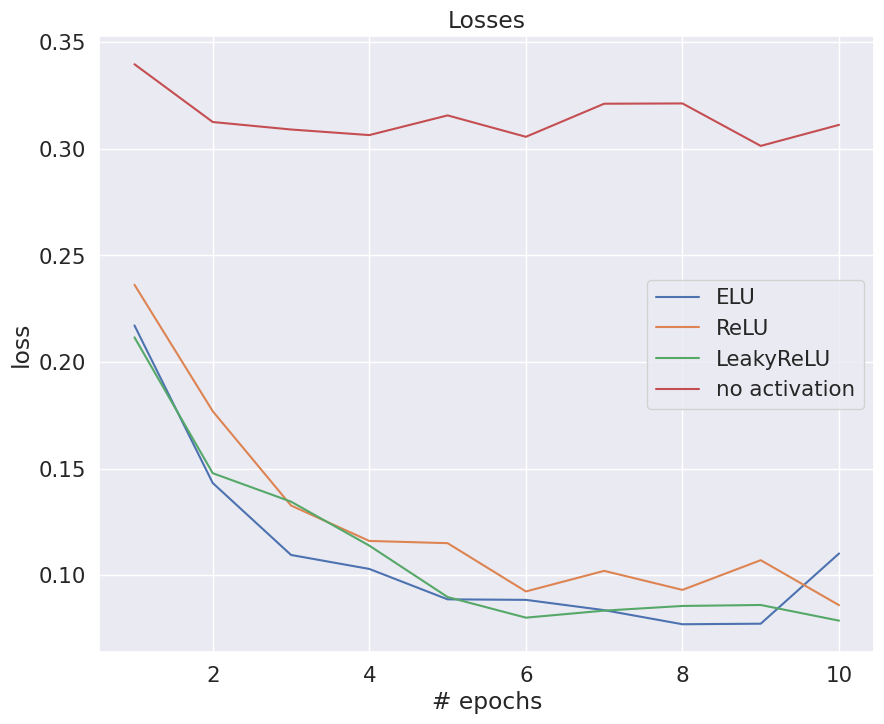

In [38]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, epochs+1), elu['val_loss'], label='ELU')
plt.plot(range(1, epochs+1), relu['val_loss'], label='ReLU')
plt.plot(range(1, epochs+1), lrelu['val_loss'], label='LeakyReLU')
plt.plot(range(1, epochs+1), identical['val_loss'], label='no activation')
plt.title('Losses')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

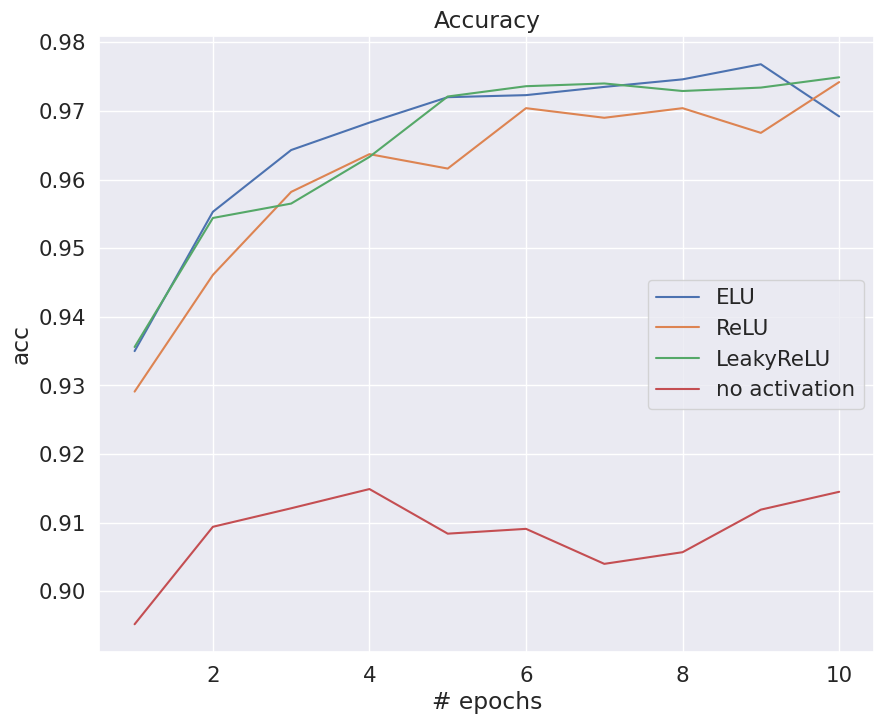

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, epochs+1), elu['val_acc'], label='ELU')
plt.plot(range(1, epochs+1), relu['val_acc'], label='ReLU')
plt.plot(range(1, epochs+1), lrelu['val_acc'], label='LeakyReLU')
plt.plot(range(1, epochs+1), identical['val_acc'], label='no activation')
plt.title('Accuracy')
plt.xlabel('# epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

As we can see activation function really helps our model to get more complex patterns.

# Convolutional Neural Networks (CNN)

Finally 🥳

### Kernel

Lets first experiment with some kernels

We will try these kernels:


1.   \begin{bmatrix}
      0 & 0 & 0\\
      0 & 1 & 0\\
      0 & 0 & 0
     \end{bmatrix}

2.   \begin{bmatrix}
      0 & 1 & 0\\
      0 & -2 & 0\\
      0 & 1 & 0
     \end{bmatrix}

3.   \begin{bmatrix}
      0 & 0 & 0\\
      1 & -2 & 1\\
      0 & 0 & 0
     \end{bmatrix}

4.   \begin{bmatrix}
      0 & 1 & 0\\
      1 & -4 & 1\\
      0 & 1 & 0
     \end{bmatrix}

5.   \begin{bmatrix}
      0 & -1 & 0\\
      -1 & 5 & -1\\
      0 & -1 & 0
     \end{bmatrix}

6.   \begin{bmatrix}
      0.0625 & 0.125 & 0.0625\\
      0.125 & 0.25 & 0.125\\
      0.0625 & 0.125 & 0.0625
     \end{bmatrix}


Okay let's choose (our victim) some image to experiment with

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

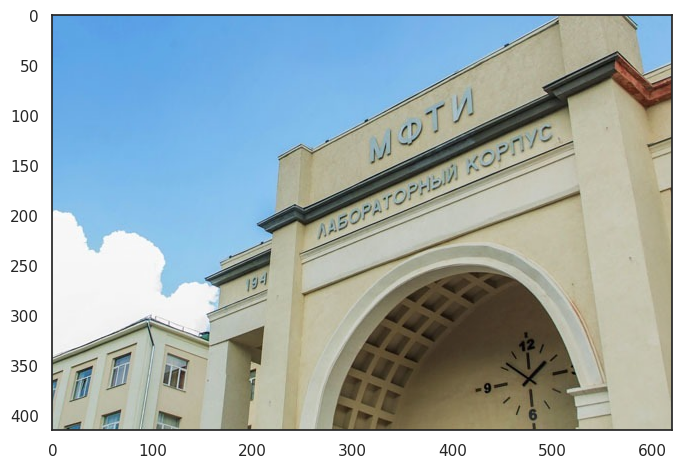

In [21]:
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(original_image)
plt.show()

In [22]:
def apply_kernel(original_image, kernel):
  img_t = torch.from_numpy(original_image).type(torch.float32).unsqueeze(0)

  kernel = kernel.repeat(3, 3, 1, 1)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  result = nn.functional.conv2d(img_t, kernel)[0]

  result_np = result.permute(1, 2, 0).numpy() / 256 / 3
  result_np = result_np.clip(0, 1)

  plt.figure(figsize=(8, 6))
  plt.subplot(1, 2, 1)
  plt.title('before')
  plt.xticks(color='w')
  plt.yticks(color='w')
  plt.imshow(original_image)
  plt.subplot(1, 2, 2);
  plt.title('after')
  plt.xticks(color='w')
  plt.yticks(color='w')
  plt.imshow(result_np)
  plt.show()

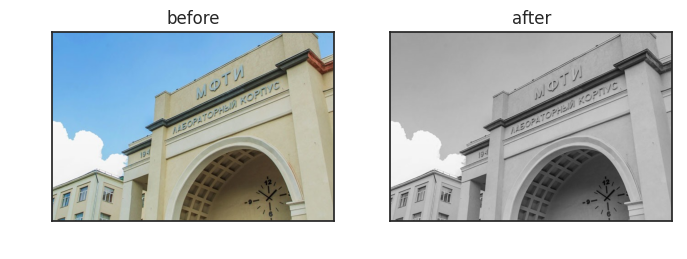

In [23]:
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

apply_kernel(original_image, kernel)

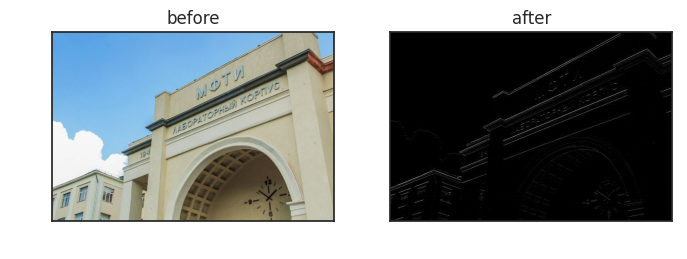

In [24]:
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

apply_kernel(original_image, kernel)

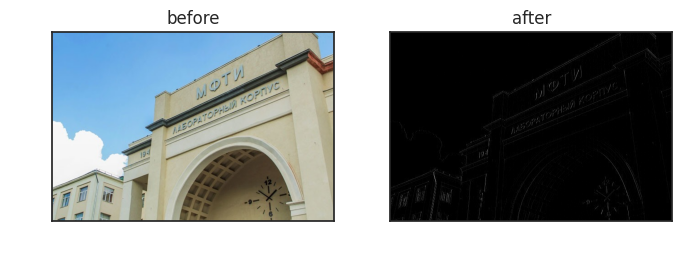

In [25]:
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

apply_kernel(original_image, kernel)

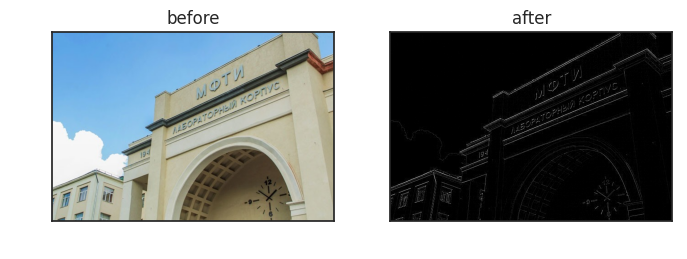

In [26]:
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

apply_kernel(original_image, kernel)

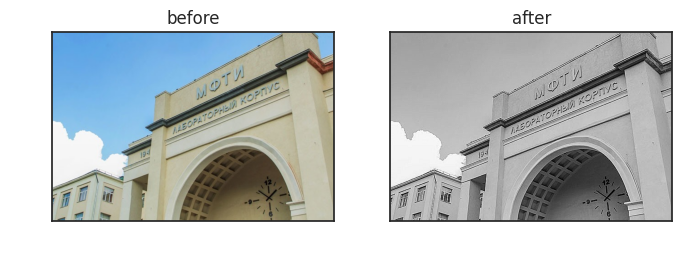

In [27]:
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

apply_kernel(original_image, kernel)

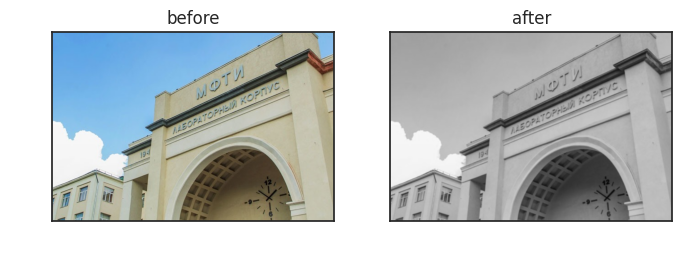

In [28]:
# blurring
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

apply_kernel(original_image, kernel)

## Task2: Implement LeNet

Use nn.Module not nn.Sequential

Our neural network should have:


*   Conv 3x3 (1 in_channels, 6 out_channels) with ReLU
*   MaxPooling 2x2
*   Conv 3x3 (6 in_channels, 16 out_channels) with ReLU
*   MaxPooling 2x2
*   nn.Flatten
*   Dense Layer with 120 neurons with ReLU
*   Dense Layer with 84 neurons with ReLU
*   Output Layer with 10 neurons






In [29]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    # let's at each step write the shape, to make everything clear
    # f - kernel size
    # n - size of the image
    # s - stride

    # (batch_size, 1, 28, 28) - (batch_size, n_channels, n, n)
    # 1 input image channel, 6 output channels, 3x3 square conv kernel
    self.conv1 = nn.Conv2d(1, 6, 3)
    # (batch_size, 6, 26, 26) - (batch_size, out_channels, n - f + 1, n - f + 1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #YOUR CODE
    # (batch_size, 6, 13, 13) - (batch_size, out_channels, (n - f) / s + 1, (n - f) / s + 1)
    self.conv2 = nn.Conv2d(6, 16, 3) #YOUR CODE
    # (batch_size, 16, 11, 11) - (batch_size, out_channels, n - f + 1, n - f + 1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #YOUR CODE
    # (batch_size, 16, 5, 5) - (batch_size, out_channels, (n - f) / s + 1, (n - f) / s + 1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = self.pool1(x)
    x = torch.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 0.001
epochs = 10

model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataloaders = {"train": train_dataloader, "val": test_dataloader}

### Lets train our LeNet model

In [31]:
history = train(model, epochs, criterion, optimizer, device, dataloaders)

Epoch 001/010:  train_loss: 0.4012066  |  val_loss: 0.1074523  |  train_acc: 0.8825833  |  val_acc: 0.9675000
Epoch 002/010:  train_loss: 0.0946831  |  val_loss: 0.0706126  |  train_acc: 0.9706500  |  val_acc: 0.9789000
Epoch 003/010:  train_loss: 0.0659604  |  val_loss: 0.0592580  |  train_acc: 0.9796333  |  val_acc: 0.9809000
Epoch 004/010:  train_loss: 0.0515117  |  val_loss: 0.0515080  |  train_acc: 0.9840833  |  val_acc: 0.9834000
Epoch 005/010:  train_loss: 0.0420705  |  val_loss: 0.0445566  |  train_acc: 0.9871167  |  val_acc: 0.9858000
Epoch 006/010:  train_loss: 0.0364381  |  val_loss: 0.0430858  |  train_acc: 0.9883333  |  val_acc: 0.9853000
Epoch 007/010:  train_loss: 0.0304513  |  val_loss: 0.0376546  |  train_acc: 0.9903833  |  val_acc: 0.9881000
Epoch 008/010:  train_loss: 0.0261818  |  val_loss: 0.0346925  |  train_acc: 0.9919500  |  val_acc: 0.9889000
Epoch 009/010:  train_loss: 0.0220033  |  val_loss: 0.0486109  |  train_acc: 0.9930333  |  val_acc: 0.9849000
Epoch 010/

In [32]:
lenet = history

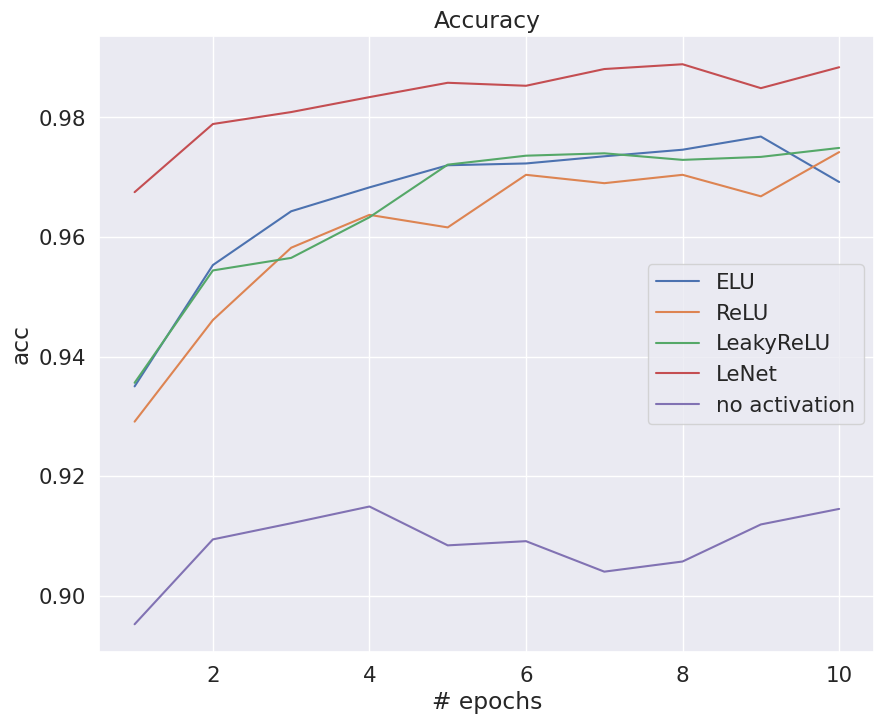

In [37]:
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid", font_scale=1.4)
plt.plot(range(1, epochs+1), elu['val_acc'], label='ELU')
plt.plot(range(1, epochs+1), relu['val_acc'], label='ReLU')
plt.plot(range(1, epochs+1), lrelu['val_acc'], label='LeakyReLU')
plt.plot(range(1, epochs+1), lenet['val_acc'], label='LeNet')
plt.plot(range(1, epochs+1), identical['val_acc'], label='no activation')
plt.title('Accuracy')
plt.xlabel('# epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

As expected CNN wins